In [4]:
import sys
sys.path.append("/home/jovyan/P1-Temp-Reg/modelbased-approach/")
import numpybased_auxiliary as aux

import numpy as np
import sirf.Gadgetron as pMR


In [7]:

filepath = "/home/jovyan/InputData/y_4.h5"

y = pMR.AcquisitionData(filepath)

frame_num = 9

y_pha = y.get_ISMRMRD_info("phase")

num_frames = int(np.max(y_pha)+1)

yshape = (y.shape[-1], num_frames, y.shape[-1])

ydata = np.zeros(yshape, dtype=y.as_array().dtype) 
mask = np.zeros(ydata.shape, dtype=np.int32)
              

for i in range(num_frames):
    ytmp = y.get_subset( np.where(y_pha == i))
    y_enc = ytmp.get_ISMRMRD_info("kspace_encode_step_1")

    mask[y_enc,i,:] = 1
    ydata[y_enc,i,:] = np.squeeze(ytmp.as_array())

ydata = np.swapaxes(ydata, 1,2)
mask = np.swapaxes(mask, 1,2)

Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..99%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5


In [8]:

x = np.fft.fftshift( \
    np.fft.ifftn( \
    np.fft.ifftshift(ydata, axes=(0,1)),axes=(0,1)),axes=(0,1))



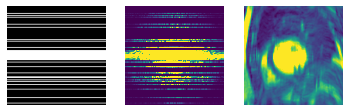

In [9]:

import matplotlib.pyplot as plt
f,ax= plt.subplots(1,3)
plot_frame = 1

ax[0].imshow(mask[...,plot_frame],cmap="gray",vmin=0,vmax=1)
ax[0].axis("off")
ax[1].imshow(np.abs(ydata[...,plot_frame]),vmin=0,vmax=20)
ax[1].axis("off")
ax[2].imshow(np.abs(x[...,plot_frame]),vmin=0,vmax=2)
ax[2].axis("off")

np.savez("/home/jovyan/data_as_matrices.npz", y=ydata, mask=mask)

In [10]:

def test_adjointness(A, yshape, tol=1e-5):
    
    yrand = np.random.randn(*yshape)
    
    AHy = A.backward(yrand)
    
    xrand = np.random.randn(*AHy.shape)
    Ax = A.forward(xrand)
    
    AHy_x = np.vdot( AHy.flatten(), xrand.flatten())
    y_Ax = np.vdot( yrand.flatten(), Ax.flatten())
    
    
    rel_tol = np.abs(y_Ax - AHy_x) / np.max(np.abs([AHy_x,y_Ax]))
    
    print(rel_tol)  
    return rel_tol < tol

def test_stacked_adjointness(A, datshape, tol=1e-5):
    
    data = np.random.randn(*datshape)
    Ax = A.forward(data)
    
    yrand = (np.random.randn(*Ax[0].shape), np.random.randn(*Ax[1].shape))
    AHy = A.backward(yrand)
    
    Ax = np.stack((Ax[0].flatten(), Ax[1].flatten()))
    yrand = np.stack((yrand[0].flatten(), yrand[1].flatten()))
    
    y_Ax = np.vdot(yrand,Ax)
    AHy_x = np.vdot( AHy.flatten(), data.flatten())
    
    
    rel_tol = np.abs(y_Ax - AHy_x) / np.max(np.abs([AHy_x,y_Ax]))
    
    print(rel_tol)  
    return rel_tol < tol

Op = aux.A(mask)
test_adjointness(Op, ydata.shape)

3.798419975342147e-16


True

In [11]:
Op = aux.Dt()
test_adjointness(Op, ydata.shape)

Op = aux.Dx()
test_stacked_adjointness(Op, ydata.shape)

9.835699610337714e-16
8.96516616777806e-16


True